# 테마주 지수 만들기

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [25]:
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

In [26]:
import FinanceDataReader as fdr

stocklst = fdr.StockListing('KRX')  # stocklst = 한국 전체 주식
stocklst.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


# 테마주 지수구하기

## 소매유통 주(df_index1)

In [54]:
# 지수 구하기 
driver = webdriver.Chrome()

company_lst = [
# 소매유통
'롯데하이마트', 
'빙그레',
'태경케미컬'#(드라이아이스-마켓컬리같은곳에 연관)
]

codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    print(code)
    df_p = fdr.DataReader(code,'2016-01-01', '2018-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2016-01-04']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index1 = pd.DataFrame(marketcap)
df_index1['total'] = df_index1.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index1['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index1['지수'] = (df_index1['total']/ marketcap_std) * 100

df_index1.reset_index(inplace=True)
df_index1.head()





    

071840
발행 주식수:  23607712.0
유동비율:  32.24
액면가:  5000
--------------------------------------------------
005180
발행 주식수:  9851241.0
유동비율:  48.86
액면가:  5000
--------------------------------------------------
006890
발행 주식수:  11600000.0
유동비율:  38.94
액면가:  500
--------------------------------------------------


,Date,롯데하이마트,빙그레,태경케미컬,total,지수
0,2016-01-04,4.338342e+13,3.205669e+13,2.841218e+11,7.572423e+13,100.000000
1,2016-01-05,4.330731e+13,3.200855e+13,2.818633e+11,7.559773e+13,99.832943
2,2016-01-06,4.566676e+13,3.248989e+13,2.841218e+11,7.844077e+13,103.587407
3,2016-01-07,4.597120e+13,3.326002e+13,2.814116e+11,7.951263e+13,105.002893
4,2016-01-08,4.444898e+13,3.354881e+13,2.777980e+11,7.827559e+13,103.369281


## 에어컨(가스)주 (df_index2)

In [55]:
driver = webdriver.Chrome()

company_lst = [
#  에어컨(가스)
'파세코',
'위니아',
'딤채',
'비엠티',
'신일전자',
'에스씨디',
'에스피지',
'위닉스' 
]

codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    print(code)
    df_p = fdr.DataReader(code,'2016-01-01', '2018-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2016-01-04']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index2 = pd.DataFrame(marketcap)
df_index2['total'] = df_index2.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index2['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index2['지수'] = (df_index2['total']/ marketcap_std) * 100

df_index2.reset_index(inplace=True)
df_index2.head()


086670
발행 주식수:  8146529.0
유동비율:  38.41
액면가:  500
--------------------------------------------------
002700
발행 주식수:  71047521.0
유동비율:  82.68
액면가:  500
--------------------------------------------------
042110
발행 주식수:  48329564.0
유동비율:  48.58
액면가:  500
--------------------------------------------------
058610
발행 주식수:  22177360.0
유동비율:  58.77
액면가:  500
--------------------------------------------------
044340
발행 주식수:  17873425.0
유동비율:  40.52
액면가:  500
--------------------------------------------------
037070
발행 주식수:  20000000.0
유동비율:  28.22
액면가:  500
--------------------------------------------------


,Date,비엠티,신일전자,에스씨디,에스피지,위닉스,파세코,total,지수
0,2016-01-04,1.408087e+11,7.107793e+11,5.012660e+11,7.233667e+11,8.545928e+11,2.101826e+11,3.140996e+12,100.000000
1,2016-01-05,1.406522e+11,6.843454e+11,5.012660e+11,7.116364e+11,8.401082e+11,2.034662e+11,3.081474e+12,98.105007
2,2016-01-06,1.406522e+11,6.814082e+11,5.024399e+11,7.090297e+11,8.220024e+11,2.008700e+11,3.056402e+12,97.306791
3,2016-01-07,1.417474e+11,6.755340e+11,4.953964e+11,6.933894e+11,7.785485e+11,1.933634e+11,2.977979e+12,94.810025
4,2016-01-08,1.408087e+11,6.637856e+11,4.977442e+11,6.933894e+11,7.640639e+11,1.930248e+11,2.952817e+12,94.008924


##  주

In [29]:
# driver = webdriver.Chrome()

# company_lst = [
# # 제습기 주
# '위닉스',
# '신일전자',
# '파세코',
# '코웨이'
# ]

# codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# # print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# # codes_lst

# marketcap = dict()

# for code in codes_lst:
# #     df = fdr.DataReader(code,'2021-01-01', '2021-12-31')
        
#     #기준시점 시가 총액(시작날짜)
#     price1 = df.loc['2018-01-02']['Close']
    
#     url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
#     driver.get(url1)
#     time.sleep(0.5)
#     html1 = driver.page_source
#     df1 = pd.read_html(html1)[1]
   
#     # 발행 주식수
#     outstanding = df1.iloc[6][1].split('/')[0]
#     outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
#     outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
#     outstanding =  float(outstanding)
#     print("발행 주식수: ",outstanding)
    
#     # 유동비율 
#     floating = df1.iloc[6][1].split('/')[1]
#     floating = floating.replace('%', '')  # %기호 없애주기
#     floating = float(floating)
#     print("유동비율: ",floating)
    
#      #액면가
#     price_f = df1.iloc[2][1]
#     price_f = price_f.replace('원', '') # 5,000원 -> 5,000
#     price_f = price_f.replace(',', '') # 5,000 -> 5000
#     price_f = int(price_f)
#     print("액면가: ", price_f)
#     print('-'* 50)
    
#     ## 지수 구하기
    
#     # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
#     #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
#     if price_f == 5000:     #액면금액이 5000원
#         pass
#     elif price_f == 2500:   #액면금액이 2500원
#         df_p['Close'] = df_p['Close']/2
        
#     elif price_f == 500:    #액면금액이 500원
#         df_p['Close'] = df_p['Close']/10
        
#     elif price_f == 100:    #액면금액이 100원
#         df_p['Close'] = df_p['Close']/50
        
#    # 회사코드 -> 회사명
#     company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
#     # 회사의 시가총액 계산
#     marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
# df_index3 = pd.DataFrame(marketcap)
# df_index3['total'] = df_index3.sum(axis=1)

# # 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

# marketcap_std = df_index3['total'].iloc[0]

# # 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
# df_index3['지수'] = (df_index3['total']/ marketcap_std) * 100

# df_index3.reset_index(inplace=True)
# df_index3.head()


# 시각화

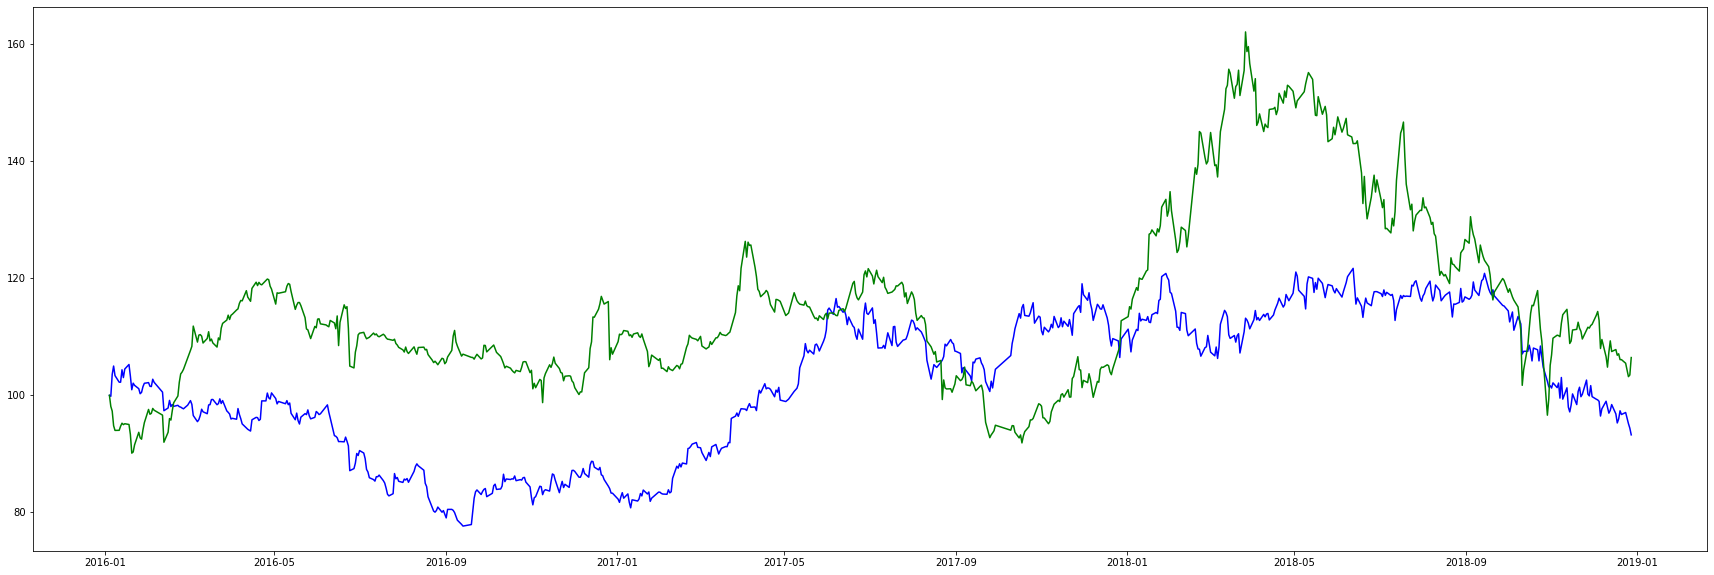

In [33]:
# matplotlib

x = df_index1['Date']
y1 = df_index1['지수']
y2 = df_index2['지수']
# y3 = df_index3['지수']
plt.figure(figsize=(30,10))
plt.plot(x,y1,'b', x,y2,'g')


# y1_scaled = df_scaled.iloc[:,-1]
# y2_scaled = df_scaled.iloc[:,-2]



## plotly

In [34]:
# plotly
# 그래프 하나로 만들기
df_total = pd.DataFrame({'Date': df_index1['Date'], '소매유통주_지수':df_index1['지수'],'에어컨주_지수':df_index2['지수']})

fig = px.line(df_total, x='Date', y=['소매유통주_지수','에어컨주_지수'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()               

In [61]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df_index11 = df_index1.set_index('Date')
df_index22 = df_index2.set_index('Date')
# df_index33 = df_index3.set_index('Date')


fig = make_subplots(
    rows=2, cols=3
    ,subplot_titles=("지수_소매유통주_2016년","지수_소매유통주_2017년","지수_소매유통주_2018년",\
                    '지수_에어컨주_2016년', "지수_에어컨주_2017년", "지수_에어컨주_2018년"))



fig.add_trace(go.Scatter(x= df_index11['2016-06':'2016-08'].index, y=df_index11['지수'].loc['2016-06':'2016-08-31']),\
              row=1, col=1) 
    

fig.add_trace(go.Scatter(x= df_index11['2017-06':'2017-08'].index, y=df_index11['지수'].loc['2017-06':'2017-08']),
              row=1, col=2)  

fig.add_trace(go.Scatter(x= df_index11['2018-05':'2018-08'].index, y=df_index11['지수'].loc['2018-05':'2018-08']),
              row=1, col=3)  

                     
fig.add_trace(go.Scatter(x=df_index22['2016-06':'2016-08'].index, y=df_index22['지수'].loc['2016-06':'2016-08']),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_index22['2017-06':'2017-08'].index, y=df_index22['지수'].loc['2017-06':'2017-08']),
              row=2, col=2)

fig.add_trace(go.Scatter(x=df_index22['2018-05':'2018-08'].index, y=df_index22['지수'].loc['2018-05':'2018-08']),
              row=2, col=3)

fig.update_layout(height=700, width=1500,
                  title_text="열대야 테마주 추세")

# # fig.show()

# # 2016년
fig.add_vline(x ='2016-07-01')
fig.add_vline(x ='2016-07-31')

# # 2017년
# fig.add_vline(x ='2017-06-30')
# fig.add_vline(x ='2017-08-28')

# 2018년
# fig.add_vline(x ='2018-05-16')
# fig.add_vline(x ='2018-06-23')
# fig.add_vline(x ='2018-07-31')






## 개별 주식의 추세

In [318]:

stocklst = fdr.StockListing('KRX')
company_lst = [
# 장마 테마주
# (1) 폐기물: 2011년 7월 27일 부근 변동성 큰 주식
'KG ETS',
'인선이엔티',
'와이엔텍',
'코엔텍',
'스페코'

]
codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list() 


price_history = dict()

for code in codes_lst:
    df = fdr.DataReader(code,'2016-01-01', '2018-12-31')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    print('회사이름: ',company_name , '회사코드: ',str(code) )
        
df_p = pd.DataFrame(price_history)
df_p.reset_index(inplace=True)

# 코드 문자열로 바꿔주기
code_str = list(map(str,codes_lst))

fig = px.line(df_p, x='Date', y= code_str)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

회사이름:  KG ETS 회사코드:  151860
회사이름:  스페코 회사코드:  013810
회사이름:  와이엔텍 회사코드:  067900
회사이름:  인선이엔티 회사코드:  060150
회사이름:  코엔텍 회사코드:  029960


In [243]:
#주가 딕셔너리에 넣기-> 유가,개별 주식간 비교에 사용

stocklst = fdr.StockListing('KRX')
company_lst = [
# 장마 테마주
# (2) 농약비료
'경농' ,
# '조비' ,
'동방아그로',
# '남해화학'
]
codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list() 


price_history = dict()

for code in codes_lst:
    df = fdr.DataReader(code,'2011-01-01', '2011-12-31')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    print('회사이름: ',company_name , '회사코드: ',str(code) )
        
df_p = pd.DataFrame(price_history)
df_p.reset_index(inplace=True)

# 코드 문자열로 바꿔주기
code_str = list(map(str,codes_lst))

fig = px.line(df_p, x='Date', y= code_str)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

회사이름:  경농 회사코드:  002100
회사이름:  동방아그로 회사코드:  007590


## 코스피, 코스닥 지수

In [307]:
# df_index = fdr.DataReader('KS100','2019-01-01','2019-12-31') 왜 안될까

In [ ]:
# ai 관련주(주로 백신) : ai가 길어지면 대체식품주 오를 수 있음

파루
제일바이오
이글벳
진원생명과학
팜스웰바이오
씨티씨바이오
대한뉴팜

